In [42]:
#!/usr/bin/env python3
#SBATCH --cpus=1
#SBATCH --gres=gpu:1
#SBATCH --mem=20GB
#SBATCH --mail-type=ALL
#SBATCH --mail-user=abstreik
#SBATCH --time=45:00:00

In [132]:
import sys 
sys.path.append('../helper')
import pandas as pd
import torch.nn as nn
import random
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import RotationMatrix
import time
from sklearn.model_selection import KFold
# from tqdm import tqdm_notebook as tqdm
tqdm = lambda x: x

In [44]:
points = pd.read_csv("../data/rotated_points_angle.csv")

In [134]:
class Net(nn.Module):
    def __init__(self, n_hidden=None):
        super().__init__()
        hidden_nodes = 50 if n_hidden is None else n_hidden
        self.ff = nn.Sequential(
            nn.Linear(1, hidden_nodes),
            nn.Sigmoid(),
            nn.Linear(hidden_nodes, 1)
        )
    
    def forward(self, x_batch):
        return self.ff(x_batch)

## Check if model can learn sine function

In [46]:
def train_sin():
    random.seed(234)
    model = Net()
    opt = Adam(model.parameters())
    model.train()
    for i in tqdm(range(300000)):
        alpha = random.uniform(0, 2*math.pi)
        pred = model(torch.Tensor([alpha]))
        y_true = math.sin(alpha)
        opt.zero_grad()
        loss = (pred - y_true) ** 2
        loss.backward()
        opt.step()
    return model

In [47]:
def plot_sin_model(model):
    test = np.linspace(0, 2*math.pi, 100)
    model.eval()
    pred = model(torch.Tensor(np.matrix(test).transpose()))
    plt.plot(test, np.sin(test))
    plt.plot(test, pred.detach().numpy())
    plt.show()

In [86]:
def plot_matrix_nets(nets):
    test = np.linspace(0, 2*math.pi, 100)
    for model in nets:
        model.eval()
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(test, np.cos(test))
    ax[0, 0].plot(test, nets[0](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[0, 1].plot(test, -np.sin(test))
    ax[0, 1].plot(test, nets[1](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[1, 0].plot(test, np.sin(test))
    ax[1, 0].plot(test, nets[2](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[1, 1].plot(test, np.cos(test))
    ax[1, 1].plot(test, nets[3](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    plt.show()

In [48]:
# plot_sin_model(train_sin())

# Train nets for matrix

In [89]:
def get_loader(data, shuffle=True):
    X = torch.FloatTensor(data[["x1", "y1", "alpha"]].values)
    y = torch.FloatTensor(data[["x2", "y2"]].values)
    torch_data = TensorDataset(X, y)
    loader = DataLoader(torch_data, batch_size=5, shuffle=shuffle)
    return loader

In [90]:
def l2_loss(y_pred, y_true, rotation_matrix):
    return (y_pred[0] - y_true[0]) ** 2 + (y_pred[1] - y_true[1]) ** 2

In [91]:
def calc_pred_loss(x_batch, y_batch, nets, loss_fn):
    alphas = x_batch[:, [2]]
    matrix_entries = [model(alphas) for model in nets]
    loss = 0
    preds = []
    for i in range(len(alphas)):
        predx = matrix_entries[0][i] * x_batch[i][0] + matrix_entries[1][i] * x_batch[i][1]
        predy = matrix_entries[2][i] * x_batch[i][0] + matrix_entries[3][i] * x_batch[i][1]
        loss += loss_fn((predx, predy), y_batch[i], [[matrix_entries[0][i], matrix_entries[1][i]], [matrix_entries[2][i], matrix_entries[3][i]]])
        preds.append((predx.item(), predy.item()))
    loss /= len(alphas)
    return {"loss": loss, "preds": preds}

In [92]:
def calc_loss(x_batch, y_batch, nets, loss_fn):
    return calc_pred_loss(x_batch, y_batch, nets, loss_fn)["loss"]

In [93]:
test_data = pd.read_csv("../data/test.csv")
# test_data = test_data[test_data.index % 20 == 0]
test_loader = get_loader(test_data, shuffle=False)

In [94]:
def test(net_ensemble, loss_fn=l2_loss, visualizePreds=False):
    test_preds = []
    test_true = []
    all_model_preds = []
    avg_test_loss = 0.0
    for nets in net_ensemble:
        model_preds = []
        for model in nets:
            model.eval()
        for x_batch, y_batch in test_loader:
            result = calc_pred_loss(x_batch, y_batch, nets, loss_fn)
            model_preds += result["preds"]
            avg_test_loss += result["loss"]
            test_true += list(y_batch)
        all_model_preds.append(model_preds)
        if visualizePreds:
            print("model preds:")
            plot_predictions(model_preds)
    avg_test_loss /= len(test_loader) * len(net_ensemble)
    for i in range(len(all_model_preds[0])):
        predx = 0
        predy = 0
        for model_preds in all_model_preds:
            predx += model_preds[i][0]
            predy += model_preds[i][1]
        predx /= len(all_model_preds)
        predy /= len(all_model_preds)
        test_preds.append((predx, predy))
    if visualizePreds:
        print("total preds:")
        plot_predictions(test_preds)
    test_loss = 0
    for y_pred, y_true in zip(test_preds, test_true):
        test_loss += loss_fn(y_pred, y_true, [[float('NaN'), float('NaN')], [float('NaN'), float('NaN')]])
    test_loss /= len(test_preds)
    return {"loss": test_loss.item(), "preds": test_preds}

In [109]:
def train(n_points_train_val, loss_fn, includeTests=False, prints=False, lastTrainResult=None, nEpochs=None, hidden_nodes=None):
    train_val_points = points.head(n_points_train_val)
    n_folds = min(n_points_train_val, 10)
    fold_indices = [(range(n_points_train_val), range(n_points_train_val))]
    if n_folds > 1:
        kf = KFold(n_folds)
        fold_indices = kf.split(train_val_points)

    train_loader = []
    val_loader = []
    for train_index, val_index in fold_indices:
        train_loader.append(get_loader(points.loc[train_index]))
        val_loader.append(get_loader(points.loc[val_index]))
    
    nets = [[Net(n_hidden=hidden_nodes) for _ in range(4)] for _ in range(n_folds)] if lastTrainResult is None else lastTrainResult["nets"]
    opts = []
    if lastTrainResult is None:
        for matrixnets in nets:
            optrow = []
            for model in matrixnets:
                optrow.append(Adam(model.parameters()))
            opts.append(optrow)
    else:
        opts = lastTrainResult["opts"]
    val_losses = [] if lastTrainResult is None else lastTrainResult["val_loss"]
    train_losses = [] if lastTrainResult is None else lastTrainResult["train_loss"]
    test_losses = [] if lastTrainResult is None else lastTrainResult["test_loss"]
    best_test_preds = None if lastTrainResult is None else lastTrainResult["best_test_preds"]
    epochs = [] if lastTrainResult is None else lastTrainResult["epochs"]
    epoch = 0 if lastTrainResult is None else (epochs[-1] + 1)
    start_epoch = epoch
    epochs_per_validation = 100 if n_points_train_val > 10 else (10 if n_points_train_val > 5 else 3)
    while True:
        epoch_val_loss = 0
        epoch_train_loss = 0
        validate = (epoch % epochs_per_validation == 0)
        for fold in range(n_folds):
            # training
            for model in nets[fold]:
                model.train()
            for x_batch, y_batch in train_loader[fold]:
                loss = calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                for opt in opts[fold]:
                    opt.zero_grad()
                loss.backward()
                for opt in opts[fold]:
                    opt.step()
            # validation
            if validate:
                for model in nets[fold]:
                    model.eval()
                val_loss = 0
                train_loss = 0
                for x_batch, y_batch in val_loader[fold]:
                    val_loss += calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                for x_batch, y_batch in train_loader[fold]:
                    train_loss += calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                val_loss /= len(val_loader[fold])
                train_loss /= len(train_loader[fold])
                epoch_val_loss += val_loss
                epoch_train_loss += train_loss

        if validate:
            epochs.append(epoch)
            epoch_val_loss /= n_folds
            epoch_train_loss /= n_folds
            val_losses.append(epoch_val_loss.item())
            train_losses.append(epoch_train_loss.item())
            if includeTests:
                test_result = test(nets, visualizePreds=False)#(epoch%1000 == 0))
                test_losses.append(test_result["loss"])
                if len(val_losses) > 1 and (best_test_preds is None or val_losses[-1] < min(val_losses[1:-1])):
                    best_test_preds = test_result["preds"]
        if prints and epoch % 500 == 0:
            print("Epoch {}:\tTrain {}\tVal {}\tTest {}".format(epoch, train_losses[-1], val_losses[-1], test_losses[-1]))
        epoch += 1
        reference_loss_index = 1000 // epochs_per_validation
        if (nEpochs is None and epoch > max(n_points_train_val * 200, 8000) and val_losses[-1] >= val_losses[-reference_loss_index]) or (nEpochs is not None and epoch - start_epoch > nEpochs):
            break
    
    return {"nets": nets, 
            "opts": opts,
            "train_loss": train_losses, 
            "val_loss": val_losses, 
            "test_loss": test_losses, 
            "best_test_preds": best_test_preds,
            "epochs": epochs
           }

In [119]:
def visualize_train(train_results, keys=["train_loss", "val_loss", "test_loss"]):
    for i, train_result in enumerate(train_results):
        for key in keys:
            plt.plot(train_result["epochs"], train_result[key], label='{}_{}'.format(key, i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

In [111]:
def plot_predictions(preds):
    plt.figure()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    for i, pred in enumerate(preds):
        test_point = test_data.iloc[i]
        plt.plot([test_point["x1"], test_point["x2"]], [test_point["y1"], test_point["y2"]], color="green", linewidth=0.5)
        plt.plot([pred[0], test_point["x2"]], [pred[1], test_point["y2"]], color="red", linewidth=0.5)

    plt.show()

## Train with n points until convergence using l2_loss

### Compare different numbers of hidden nodes

Start calculation for 5 hidden nodes.
Epoch 0:	Train 1.2656217813491821	Val 1.5933802127838135	Test 1.0181365013122559
Epoch 300:	Train 0.6382061243057251	Val 1.4919408559799194	Test 1.0879310369491577
Epoch 600:	Train 0.5220001339912415	Val 1.4592114686965942	Test 0.9842110872268677
Epoch 900:	Train 0.4240238666534424	Val 1.3467357158660889	Test 0.9003166556358337
Epoch 1200:	Train 0.3526032567024231	Val 1.2442187070846558	Test 0.8430065512657166
Epoch 1500:	Train 0.30334529280662537	Val 1.1954865455627441	Test 0.7966758608818054
Epoch 1800:	Train 0.2630772292613983	Val 1.1889588832855225	Test 0.7498970031738281
Epoch 2100:	Train 0.22705340385437012	Val 1.1890366077423096	Test 0.7006592750549316
Epoch 2400:	Train 0.1945725679397583	Val 1.179792046546936	Test 0.6492157578468323
Epoch 2700:	Train 0.16602441668510437	Val 1.1588841676712036	Test 0.5978251695632935
Epoch 3000:	Train 0.1424407958984375	Val 1.126903772354126	Test 0.5486020445823669
Epoch 3300:	Train 0.12176742404699326	Val 1

Epoch 13200:	Train 0.0025432747788727283	Val 0.6774967312812805	Test 0.33639925718307495
Epoch 13500:	Train 0.002451749052852392	Val 0.6839764714241028	Test 0.338133305311203
Epoch 13800:	Train 0.002372993854805827	Val 0.6951085329055786	Test 0.34042951464653015
Epoch 14100:	Train 0.0022897543385624886	Val 0.7057258486747742	Test 0.3421088457107544
Epoch 14400:	Train 0.0022196294739842415	Val 0.7164481282234192	Test 0.3442666530609131
Epoch 14700:	Train 0.0021506831981241703	Val 0.7281302213668823	Test 0.3456456661224365
Epoch 15000:	Train 0.0020879667717963457	Val 0.7354400753974915	Test 0.34755778312683105
Start calculation for 20 hidden nodes.
Epoch 0:	Train 1.228351354598999	Val 1.5881725549697876	Test 1.0808171033859253
Epoch 300:	Train 0.4562312960624695	Val 1.365513563156128	Test 0.9316295981407166
Epoch 600:	Train 0.3013565242290497	Val 1.388683557510376	Test 0.8076733350753784
Epoch 900:	Train 0.21543550491333008	Val 1.4900320768356323	Test 0.6902016401290894
Epoch 1200:	Train

Epoch 10800:	Train 0.003195617813616991	Val 0.4415082037448883	Test 0.21146881580352783
Epoch 11100:	Train 0.0030639786273241043	Val 0.4226040244102478	Test 0.21459442377090454
Epoch 11400:	Train 0.0029785274527966976	Val 0.41714611649513245	Test 0.21751514077186584
Epoch 11700:	Train 0.002847019350156188	Val 0.40533310174942017	Test 0.22022129595279694
Epoch 12000:	Train 0.0027681165374815464	Val 0.3914874494075775	Test 0.22141417860984802
Epoch 12300:	Train 0.0026576474774628878	Val 0.38211768865585327	Test 0.2229185700416565
Epoch 12600:	Train 0.0025909740943461657	Val 0.37386733293533325	Test 0.22337090969085693
Epoch 12900:	Train 0.0024890154600143433	Val 0.36507880687713623	Test 0.22462567687034607
Epoch 13200:	Train 0.002401809673756361	Val 0.35993534326553345	Test 0.22551746666431427
Epoch 13500:	Train 0.002353407209739089	Val 0.34644773602485657	Test 0.22519323229789734
Epoch 13800:	Train 0.002278198953717947	Val 0.344333291053772	Test 0.22493092715740204
Epoch 14100:	Train 0.

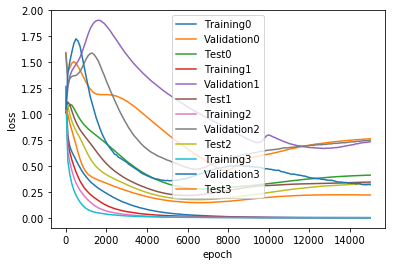

In [115]:
results_hidden_nodes = []
n_points_train_val = 10
for n_hidden in [5]:#[5, 10, 20, 50, 100]:
    print("Start calculation for {} hidden nodes.".format(n_hidden))
    nEpochs = 100#20000 if n_hidden < 50 else 70000
    train_result = train(n_points_train_val, l2_loss, includeTests=True, prints=True, nEpochs=nEpochs, hidden_nodes=n_hidden)
    results_hidden_nodes.append([n_hidden, train_result])
results_hidden_nodes = pd.DataFrame(results_hidden_nodes, columns=["n_hidden", "train_result"])
results_hidden_nodes.to_csv("results_hidden_nodes.csv", index=False)

In [ ]:
# results_hidden_nodes = pd.read_csv("results_hidden_nodes.csv")
# df["train_result"] = df.apply(lambda row: eval(row["train_result"]), axis=1)

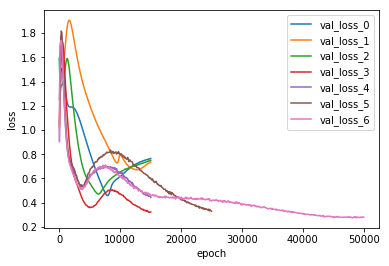

In [129]:
# visualize_train(results_hidden_nodes["train_result"], keys=["val_loss"])

Result: Choose 50 hidden nodes (almost same validation loss with much less epochs)

### Calculate for different numbers of points and save results

In [103]:
results_limited_data = []
for n_points_train_val in range(1, 36):
    print("Start calculation for {} points.".format(n_points_train_val))
    starttime = time.time()
    train_result = train(n_points_train_val, l2_loss, includeTests=True, prints=True)
    results_limited_data.append([n_points_train_val, str(train_result.drop(columns=["nets", "opts"])), time.time() - starttime])
    if n_points_train_val >= 20 and n_points_train_val % 5 == 0:
        df = pd.DataFrame(results_limited_data, columns=["n_points_train_val", "train_result", "execution_time"])
        df.to_csv("train_limited_data_results_{}.csv".format(n_points_train_val), index=False)
results_limited_data = pd.DataFrame(results_limited_data, columns=["n_points_train_val", "train_result", "execution_time"])
results_limited_data.to_csv("results_limited_data.csv", index=False)

Start calculation for 11 points.
Epoch 0:	Train 1.1863034963607788	Val 1.043672800064087	Test 1.013802170753479
Epoch 100:	Train 0.5618268847465515	Val 1.3793516159057617	Test 1.0162570476531982
Epoch 200:	Train 0.43317651748657227	Val 1.4479765892028809	Test 0.9132641553878784
Epoch 300:	Train 0.34183016419410706	Val 1.4632699489593506	Test 0.847815990447998
Epoch 400:	Train 0.28011733293533325	Val 1.4955203533172607	Test 0.7913162708282471
Epoch 500:	Train 0.23639965057373047	Val 1.5305837392807007	Test 0.7312520146369934
Epoch 600:	Train 0.19970659911632538	Val 1.5614252090454102	Test 0.6672553420066833
Epoch 700:	Train 0.17110061645507812	Val 1.5636699199676514	Test 0.6055024862289429
Epoch 800:	Train 0.14513972401618958	Val 1.5403518676757812	Test 0.5515664219856262
Epoch 900:	Train 0.12398377805948257	Val 1.4937855005264282	Test 0.5088491439819336
Epoch 1000:	Train 0.10609950125217438	Val 1.4371559619903564	Test 0.4730468690395355
Epoch 1100:	Train 0.09193114936351776	Val 1.38000

KeyboardInterrupt: 

In [ ]:
# results_limited_data = pd.read_csv("train_limited_data_results_{}.csv", index_col="n_points_train_val")
# results_limited_data["train_result"] = results.apply(lambda row: eval(row["train_result"]), axis=1)

## Add different loss functions

In [64]:
def norm_loss(y_pred, y_true, rotation_matrix):
    return (l2_loss(y_pred, (0,0), np.zeros((2,2))) - 1) ** 2

In [65]:
def det_loss(y_pred, y_true, rotation_matrix):
    det = rotation_matrix[0][0] * rotation_matrix[1][1] - rotation_matrix[0][1] * rotation_matrix[1][0]
    return (det - 1) ** 2

In [66]:
# first weight is for l2_loss, second weight for det_loss, third for norm loss
def get_mixed_lossfn(weigths):
    def mixed_loss(y_pred, y_true, rotation_matrix):
        l0 = l2_loss(y_pred, y_true, rotation_matrix)
        l1 = det_loss(y_pred, y_true, rotation_matrix)
        l2 = norm_loss(y_pred, y_true, rotation_matrix)
        return weigths[0] * l0 + weigths[1] * l1 + weigths[2] * l2
    return mixed_loss

In [ ]:
# Choose a specific number of points to further experiment with
n_points_train_val = 11

In [34]:
# train_result_mixed = train(n_points_train_val, get_mixed_lossfn((1, 2, 0.2)), includeTests=True, prints=True)

In [ ]:
visualize_train([results["train_result"][n_points_train_val], train_result_mixed])

Results: 
(1, 2, 0.2) is better, converges to 0.08 test loss
(1, 2, 8) is worse
(1, 4, 0.2) really bad

# NEXT: Try different weights, try dynamically changing loss functions